In [203]:
import sys 
sys.path.append('../')
from utils.viz import two_data_time_viz, one_data_time_viz
from torch.autograd import Variable
from nn.crossformer import CrossFormer
from data.dataloader import NumpyMetaDataset 
from nn.crossodeformer import CrossFormer
import matplotlib.pylab as plt
import torch 
import numpy as np
import phate

# import argparse
# import time
# import os 
# import torch 
# import sys 
# from data.dataloader02 import NumpyMetaDataset 
# from matplotlib import pyplot
# import umap 
# import pandas as pd
# import statsmodels.api as sm
# 
# # from pandas.plotting import andrews_curves
# from torch.autograd import Variable
# from nn.crossformer import CrossFormer
# 
# from sklearn.decomposition import PCA

from nilearn.datasets import fetch_surf_fsaverage
from nilearn import surface
from nilearn import plotting

num_colors = 110
base_colormap = plt.cm.get_cmap("tab20", 20)
num_repeats = int(np.ceil(num_colors / 20.0))

colors = []
for i in range(num_colors):
    base_color = base_colormap(i % 20)
    factor = 1 - 0.5 * (i // 20) / num_repeats
    color = [channel * factor for channel in base_color[:3]]
    colors.append(tuple(color + [1.0]))
 
colormap = plt.cm.get_cmap("coolwarm", num_colors)
heat_colors = [colormap(i) for i in range(num_colors)]


/tmp/ipykernel_1112085/123334686.py:35: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  base_colormap = plt.cm.get_cmap("tab20", 20)
/tmp/ipykernel_1112085/123334686.py:45: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colormap = plt.cm.get_cmap("coolwarm", num_colors)


In [204]:
device = 'cpu'
dataloader = NumpyMetaDataset(
    meg_dir = '/gpfs/gibbs/pi/krishnaswamy_smita/fmri-meg/meg/samples_240/train/', 
    fmri_dir =  '/gpfs/gibbs/pi/krishnaswamy_smita/fmri-meg/fmri/samples_30/train/', 
    n_way = 100, 
    batch_size = 1, 
    shuffle=True
) 

for it, ((xm, xf, y_meta, y_batch), [time, sub_f, sub_m]) in enumerate(dataloader): 
    break
     
xm = torch.stack([torch.from_numpy(arr) for arr in xm]).squeeze(1) #.to(device)
xf = torch.stack([torch.from_numpy(arr) for arr in xf]).squeeze(1) #.to(device)
    
xm, xf = xm.float(), xf.float() 
xm, xf = Variable(xm.float()), Variable(xf.float()) 
xm = torch.nn.functional.normalize(xm, p=2.0, dim=-1) 
xf = torch.nn.functional.normalize(xf, p=2.0, dim=-1)

In [208]:
device = 'cpu'
model = CrossFormer(
        input_dim = 20484,
        dim = 1024, 
        depth = 6, 
        heads = 8, 
        mlp_dim = 1024, 
        dim_head = 64,
        device = device)

it = 500
key = 'contrastive-20230418-063420'
pwd = '/home/aa2793/gibbs/arman/yale23/fMRI-Reconstruction/outputs/train_logs/ith_and_best_model/'+ key+'/ith_'+str(it)+'_model'+key+'.pth'

model_pth = torch.load(pwd, map_location=torch.device('cpu'))
model.load_state_dict(model_pth['model'])

<All keys matched successfully>

In [209]:
[loss_a, loss_m, loss_f], acc_a, [xm, xf, zf, zm, zf_tf, zm_tf, xm_hat, xf_hat] = model.forward_contrastive(xm, xf)

torch.Size([100, 240, 20484])


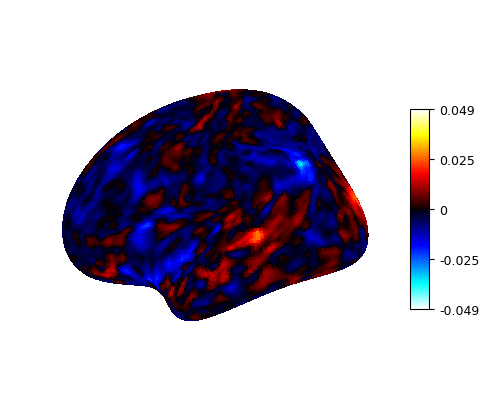

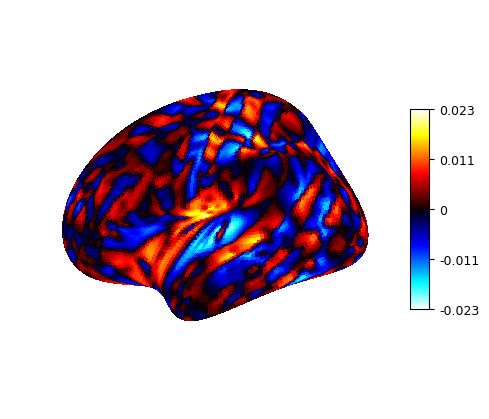

In [210]:
print(xm.shape)
brain_map_left(data = xf[4, : , :], sample_index=10)
brain_map_left(data = xm[4, : , :], sample_index=10)

In [211]:
def brain_map_left_mean(data):  
    data_lh = data[:, :10242].mean(0).detach().numpy() 
    fsaverage_surface = fetch_surf_fsaverage(mesh='fsaverage5') # has 10242 per hemisphere, so 20848 total
    inflated_mesh_lh = fsaverage_surface["infl_left"] # specify hemispheres separately
    sulc_mesh_lh = fsaverage_surface['sulc_left'] 
    plotting.plot_surf_stat_map(inflated_mesh_lh, 
                                data_lh, 
                                hemi='left', 
                                view='lateral',  # {‘lateral’, ‘medial’, ‘dorsal’, ‘ventral’, ‘anterior’, ‘posterior’}
                                bg_map=sulc_mesh_lh) 
#                                 axes=axes1) # visualizes the first sample 

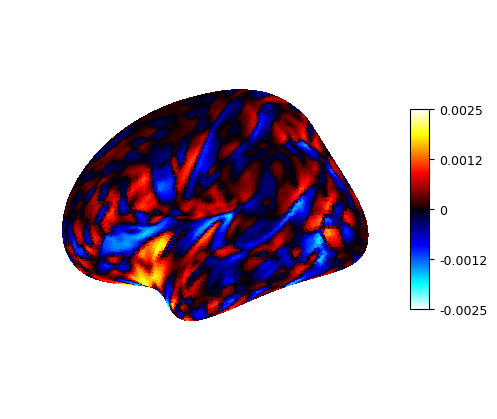

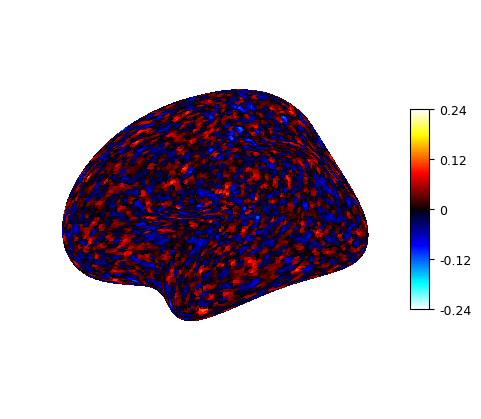

In [212]:
brain_map_left_mean(data = xm[3, : , :])
brain_map_left_mean(data = xm_hat[3, : , :])

In [213]:
def x_viz_fun(x, method = 'phate', comment='text', colored=True, heat = True): 
    if heat:
        colors_list = heat_colors
    else:
        colors_list = colors 
        
    batch_size, num_samples, dim = x.shape
    plt.figure(figsize=(6, 6))
    plt.rcParams.update({'font.size': 9})
    
    if method == 'phate':
        x2d = phate.PHATE(verbose = False).fit_transform(x.detach().reshape(-1, x.shape[-1]))
    elif method == 'pca':
        x2d = PCA(2).fit_transform(x.detach().reshape(-1, x.shape[-1]).numpy())    
        
    if colored:    
        x2d = torch.tensor(x2d).unsqueeze(1).view(batch_size, num_samples, -1) 
        
        for t in range(0, int(batch_size/2)):  
            plt.scatter(x2d[t,  :][:, 0], x2d[t,  :][:, 1], marker="o", s=6 , color=colors_list[t], alpha=0.7)

        for t in range(int(batch_size/2), batch_size):  
            plt.scatter(x2d[t,  :][:, 0], x2d[t,  :][:, 1], marker="*", s=6 , color=colors_list[t-int(batch_size/2)], alpha=0.7)
            
    else:
        plt.scatter(z_viz[:, 0], z_viz[:, 1], marker="o", s=15, color='blue', alpha=0.1)
         
    plt.xlabel('Phate 1', fontsize=12)
    plt.ylabel('Phate 2', fontsize=12)
    plt.title(comment, fontsize=12)
    plt.show
    
    return x2d


def alignment_viz(z_all_2d):
    batch_size, num_samples, dim = z_all_2d.shape 
    
    batch_size = int(batch_size/2) 
    z_real = torch.tensor(z_all_2d[:batch_size, :, :]).view(batch_size, num_samples, 2)
    z_cros = torch.tensor(z_all_2d[batch_size:, :, :]).view(batch_size, num_samples, 2) 
    fig, axs = plt.subplots(nrows=10, ncols=10, figsize=(10, 10))
    n_rows = int(batch_size/10) 

    t = 0
    for i in range(10): 
        for j in range(n_rows):   

            z_real_t = z_real[t, :, :]  
            z_cros_t = z_cros[t, :, :]   

            for s in range(z_all_2d.shape[1]):  
                if s%2==0:
                    axs[i,j].scatter(z_real_t[s, 0], z_real_t[s, 1], marker="*", s=25, color='red', alpha=0.2)
                    axs[i,j].scatter(z_cros_t[s, 0], z_cros_t[s, 1], marker="o", s=25, color='blue', alpha=0.3)
                else:
                    axs[i,j].scatter(z_cros_t[s, 0], z_cros_t[s, 1], marker="o", s=25, color='blue', alpha=0.2)
                    axs[i,j].scatter(z_real_t[s, 0], z_real_t[s, 1], marker="*", s=25, color='red', alpha=0.3)

            t += 1 

            axs[i,j].set_xlabel('')
            axs[i,j].set_ylabel('')

            axs[i,j].set_xticks([])
            axs[i,j].set_yticks([])
            axs[i,j].spines['top'].set_alpha(0.1)
            axs[i,j].spines['right'].set_alpha(0.1)
            axs[i,j].spines['bottom'].set_alpha(0.1)
            axs[i,j].spines['left'].set_alpha(0.1) 

# fMRI alignment visualization

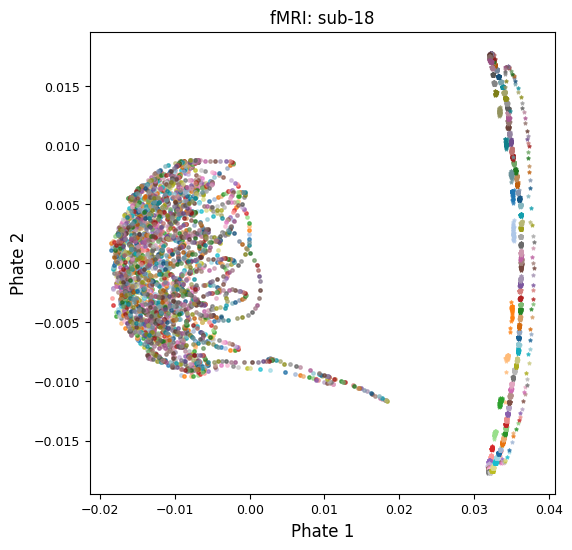

In [175]:
zf_all_2d = x_viz_fun(
    x = torch.cat((zf, zf_tf), dim = 0), 
    method = 'phate', 
    comment = 'fMRI: ' + sub_f, 
    colored = True, 
    heat = False
)

batch_size = int(batch_size/2)  100


/tmp/ipykernel_1112085/2435327082.py:41: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z_real = torch.tensor(z_all_2d[:batch_size, :, :]).view(batch_size, num_samples, 2)
/tmp/ipykernel_1112085/2435327082.py:42: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z_cros = torch.tensor(z_all_2d[batch_size:, :, :]).view(batch_size, num_samples, 2)


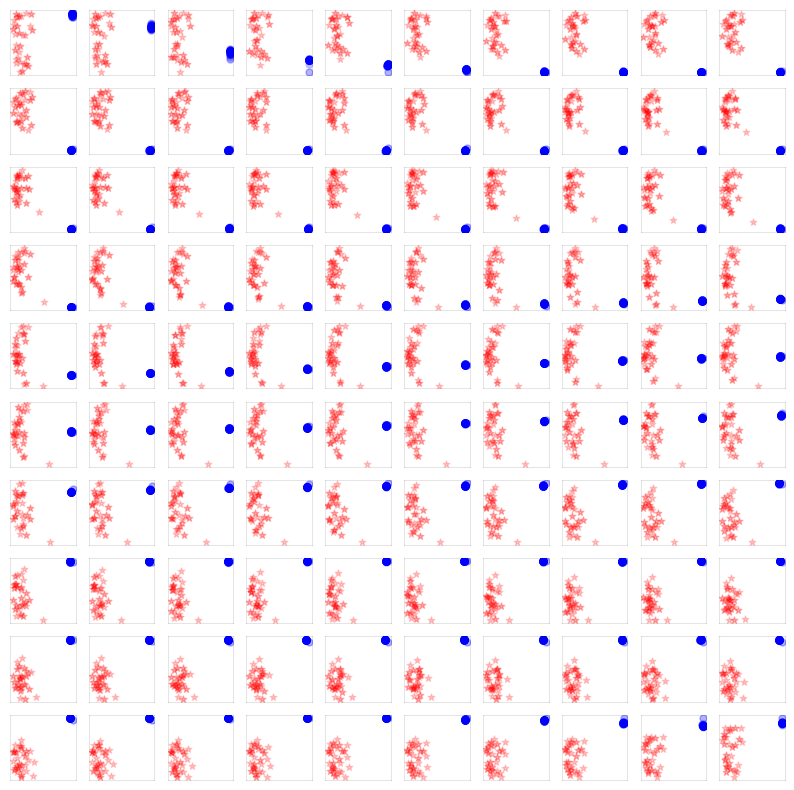

In [176]:
alignment_viz(zf_all_2d)

# MEG alignment visualization

In [ ]:
zm_all_2d = x_viz_fun(
    x = torch.cat((zm, zm_tf), dim = 0), 
    method = 'phate', 
    comment = 'MEG: ' + sub_m, 
    colored = True, 
    heat = False
)

In [ ]:
alignment_viz(zm_all_2d)

# Reconstruction phates

In [194]:
def pca_phate(x, viz_method = 'phate', colored=True):
    plt.figure(figsize=(10, 10))
    plt.rcParams.update({'font.size': 9}) 
    x_viz = x.reshape(-1, x.shape[-1]).numpy()
    if viz_method == 'phate':
        # z_viz = phate.PHATE(2,  k=15, t = 5).fit_transform(x_viz)
        z_viz = phate.PHATE(verbose = False).fit_transform(x_viz)
    elif viz_method == 'pca': 
        z_viz = PCA(2).fit_transform(x_viz) 
        
    if colored:
        z_viz = torch.tensor(z_viz).view(100, xm_hat.shape[1], z_viz.shape[-1])
        plt.figure(figsize=(10, 10))
        plt.rcParams.update({'font.size': 9})  
        for t in range(z_viz.shape[0]): 
            plt.scatter(z_viz[t, :, :][:, 0], z_viz[t, :, :][:, 1], marker="o", s=15, color=colors[t], alpha=0.4)
    else:
        plt.scatter(z_viz[:, 0], z_viz[:, 1], marker="o", s=15, color='gray', alpha=0.3)
    
    print(z_viz.shape)
    return z_viz

    Using SMACOF because SGD returned NaN


/gpfs/gibbs/project/krishnaswamy_smita/aa2793/conda_envs/pytorch_fmri/lib/python3.9/site-packages/sklearn/manifold/_mds.py:299: FutureWarning: The default value of `normalized_stress` will change to `'auto'` in version 1.4. To suppress this warning, manually set the value of `normalized_stress`.
  warnings.warn(


torch.Size([100, 240, 2])


<Figure size 1000x1000 with 0 Axes>

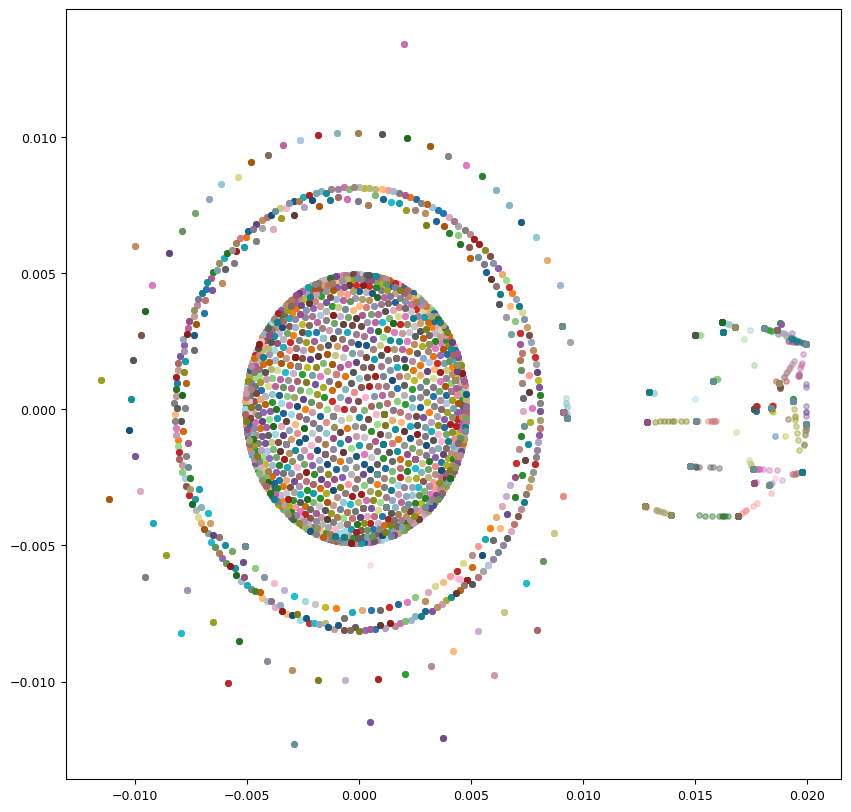

In [195]:
z_viz = pca_phate(xm_hat.detach(), viz_method = 'phate', colored=True)

z_viz.shape (28620, 2)


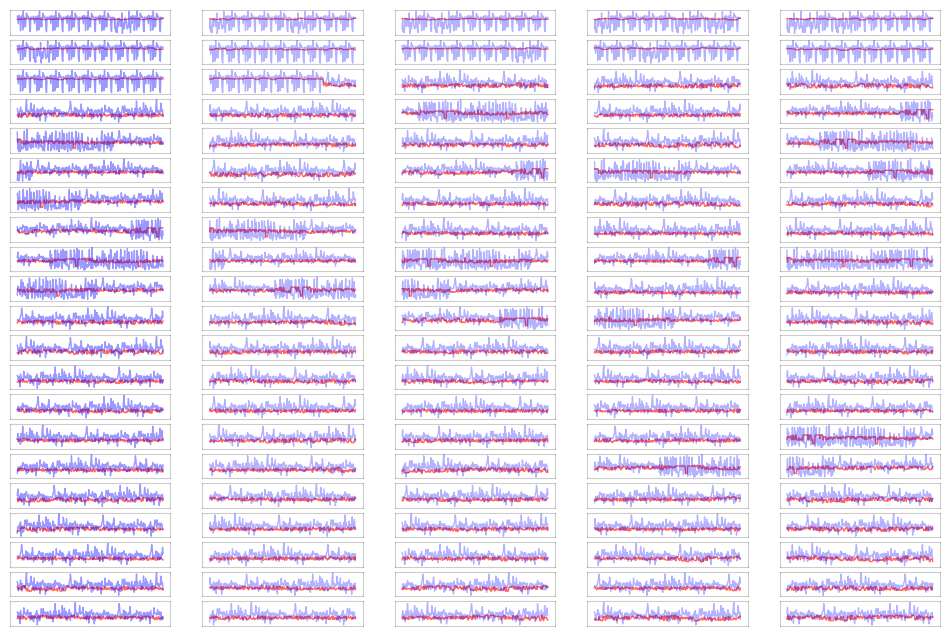

In [69]:


print("z_viz.shape", z_viz.shape)
data1 = torch.tensor(z_viz)  
data2 = torch.tensor(z_viz_hat)

data1 = data1.reshape(106, -1, 2)  
data2 = data2.reshape(106, -1, 2)
fig, axs = plt.subplots(nrows=21, ncols=5, figsize=(12, 8))
 
time = 0
for i in range(21):
    for j in range(5):
        x1 = data1[time, :, :].numpy() 
        x2 = data2[time, :, :].numpy() 
        time += 1
        if j == 0:
            axs[i,j].plot(x1[:, 0], color='red', alpha=0.6, linewidth=1) 
            axs[i,j].plot(x2[:, 0], color='blue', alpha=0.4, linewidth=1) 
        elif j == 1:
            axs[i,j].plot(x1[:, 0], color='red', alpha=0.6, linewidth=1) 
            axs[i,j].plot(x2[:, 0], color='blue', alpha=0.3, linewidth=1)
        else:
            axs[i,j].plot(x1[:, 0], color='red', alpha=0.6, linewidth=1)  
            axs[i,j].plot(x2[:, 0], color='blue', alpha=0.3, linewidth=1)
        axs[i,j].set_xlabel('')
        axs[i,j].set_ylabel('')
        
        axs[i,j].set_xticks([])
        axs[i,j].set_yticks([])
        axs[i,j].spines['top'].set_alpha(0.2)
        axs[i,j].spines['right'].set_alpha(0.2)
        axs[i,j].spines['bottom'].set_alpha(0.2)
        axs[i,j].spines['left'].set_alpha(0.2) 

# show the plot
plt.show()